# Introduction to Spatial Clustering

-----

In this notebook, we introduce [clustering][wcl], a machine learning task where one tries to identify groups or clusters of data. Clustering is generally an unsupervised learning technique, since we are simply using the data features to determine some concept of _closeness_. One common technique used to quantify clustering is to identify clusters by using a metric, or distance measure. For example, we can use the [_Euclidean metric_][edm] when all the data have the same units (such as distance) and dimensions. Other distance measures can be used when appropriate for the given data to determine closeness or similarity.

Specifically, this notebook focuses on [k-means clustering][wkm], where we seek to divide $N$ data points into $k$ clusters. First, the k-means algorithm will be introduced and demonstrated on the Iris data. Next, the _elbow method_ is introduced as a technique for determining the best value for $k$. Finally, this cluster finding technique will be demonstrated on the larger, credit card data, which will also include a discussion on the algorithm's performance.

-----
[wcl]: https://en.wikipedia.org/wiki/Cluster_analysis
[edm]: https://en.wikipedia.org/wiki/Euclidean_distance
[wkm]: https://en.wikipedia.org/wiki/K-means_clustering

## Table of Contents

[Formalism](#Formalism)

[k-Means: Iris Data](#k-Means:-Iris-Data)
- [k-Means:Elbow Method](#k-Means:Elbow-Method)

[k-Means: Digit Data](#k-Means:-Digit-Data)
- [k-Means: Performance](#k-Means:-Performance)
- [k-Means: Dimensional Reduction](#k-Means:-Dimensional-Reduction)
- [k-Means: Manifold Learning](#k-Means:-Manifold-Learning)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

Data often have naturally occurring groups or clusters; we have used this fact to perform classification. In some cases, however, we wish to understand the groups, or clusters themselves. Thus, we also need to find the clusters in order to quantify their properties (such as size or density) as well as to identify their members. Formally, cluster finding seeks to first find $k$ clusters from a set of $N$ data points, and to subsequently identify which data points belong to each cluster. 

While there are a number of different approaches to clustering, one of the easiest to understand is the k-means algorithm. In this algorithm we start with a guess for $k$, the number of clusters (this can be based on prior information or iteratively quantified). We randomly place cluster centers in the data and determine how well the data _cluster_ to these cluster centers. This information is used to pick new cluster centers, via a weighting process (for the k-means algorithm we take the mean of the points assigned to each cluster), and the process continues until a solution converges (or we reach a predefined number of iterations). 

In general, the k-means algorithm can be quite fast. However, as $N$ becomes larger, this task can become computationally difficult since the distances between each cluster center and each data point must be repeatedly calculated. In addition, the k-means algorithm is iterative where the cluster centers are repeatedly updated, and new distances calculated. Finally, the k-means algorithm can become trapped in a local minima. To avoid this, the k-means algorithm is typically run multiple times, each with a different set of random cluster locations, and the best result is selected in the end.

Essentially, the k-means algorithm works as follows:
1. Randomly pick k data points from the data set as initial centers(sometimes called the _centroids_). There are various methods to choose initial centers and the methods have big impact on the k-means performance. The way to choose initial centers is out of the scope of this course. But they all have some randomness in them.
2. Assign each data point in the data set to the closest center. Now we have k clusters, each has a center and data points assigned to the center.
3. Calcuate the mean(the real center) of each cluster, use it as new center. Now we have k new centers.
4. Repeat step 2&3(there's a great animation that demonstrates the 2 steps on [wikipedia][wkc]) until one of the following two conditions met:
 1. There's no change in data from step 2 to step 3
 2. Total iteration of step 2&3 reaches to a pre-defined maximum number of iterations(*max_iter*).  
5. Now we have found the best centers relative to the randomly picked initial centers. Calculate the distance from each data point to its center and add up all the distances together to get a total distance D.
6. To avoid local minima, repeat step 1-6 with new randomly picked initial centers. Repeat a pre-defined number(_n_init_) of times. 
7. The set of centers which has the minimum total distance D is the final centers. Now the k clusters are determined.

Just like k-nearest neighbors(KNN), k-means relies on calculation of distances between data points. So it's important to **standardize** the data to have a mean of zero and a standard deviation of one since the features in any dataset almost always would have different units of measurements.

-----
[wkc]:https://en.wikipedia.org/wiki/K-means_clustering

[[Back to TOC]](#Table-of-Contents)


## k-Means: Iris Data

To introduce the k-means cluster algorithm, we will start by using the standard Iris data set. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width. The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris Setosa, Iris Versicolor, and Iris Virginica. 

Before proceeding with the k-means algorithm, we first need to load and pre-process these data. The following Code cell loads the Iris data into the notebook and extracts the features and labels. Next, the features are scaled to all have zero mean and unit standard deviation. This ensures each feature is treated uniformly during the cluster finding process.

Clustering doesn't need label. We create label here just for visualization purpose.

-----

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the digits data
iris = sns.load_dataset('iris')
    
# standardize the features
x = StandardScaler().fit_transform(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
# encode species to get labels, this is for visulization only
y = LabelEncoder().fit_transform(iris.species)

-----

[[Back to TOC]](#Table-of-Contents)

### Principal Component Analysis

The iris data set has four features which makes it hard to visualize the clusters. To make visualization easier, we will reduce the data set to two features by using principal component analysis, or [PCA][skpca].

Principal component analysis(PCA), is a technique to perform dimensional reduction. PCA effectively rotates the data into a new set of reduced dimensions. Thus, by employing PCA, we can often identify a reduced set of features that we can use to perform machine learning, while retaining the majority of the signal we wish to model. This can result in faster computations and reliable models since we have reduced the amount of noise used to train the model.

The PCA transformer requires one tunable parameter that specifies the target number of dimensions. This value can be arbitrarily selected, perhaps based on a prior information, or it can be iteratively determined.

In the next code cell, we create a two-dimensional representation of the Iris data by using PCA defined in the scikit learn module. This reduced set of features will be used to visualize the results of the k-means algorithm. 

**Note:** the reduced dataset is used for visualization only. To train the k-means model, we still use original dataset which has 4 features.

In the following code, we also append the label to the two-dimensional data set. This is also only for visualization purpose. In order to concatenate label with the data set, we need to reshape label from a flat numpy array to a numpy array that has same number of rows as the dataset. For example, if there are 150 rows in the iris dataset, we need to reshape the label to a numpy array with 150 rows and one column. 

-----
[skpca]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [3]:
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
x_pca = pca.fit_transform(x)

# append label to reduced dataset.
x_pca_label = np.concatenate((x_pca, y.reshape(x.shape[0], 1)), axis=1)

-----

### k-Means: Clustering

We perform k-means clustering by using the [`KMeans`][skkm] estimator within the `cluster` module of the scikit learn library. This algorithm accepts a number of hyperparameters that control its performance, some of the most commonly changed include:
- `n_clusters`: the number of clusters, $k$, the algorithm will find, the default value is eight.
- `n_init`: the number of times the algorithm is run with different initial cluster centers, the default is ten.
- `max_iter`: maximum number of iterations for the algorithm in any given run, the default is 300.
- `random_state`: random seed used by the random number generator, enables reproducibility.

In the following Code cell, we perform k-means cluster finding on the Iris data. We create the estimator by specifying three clusters (one for each species), by indicating that twenty-five different runs should be performed, and by specifying a random state for reproducibility. 

After the estimator is created, we `fit` the model to the data which identifies the cluster centers. Note, this process is unsupervised in that we do not use the label in this process. In addition, we perform the cluster finding by using all features (which in this case is four). 

After we find our cluster centers, we `predict` to which cluster each data point belongs.

-----
[skkm]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [4]:
# We will use kmeans form scikit-learn
from sklearn.cluster import KMeans

# We build our model assuming three clusters
k_means = KMeans(n_clusters=3, n_init=25, random_state=23)

# We fit our original data to assign classes
k_means.fit(x)

# Obtain the predictions
y_cluster = k_means.predict(x)

---
In the next code cell, we get a count of data points in the 3 clusters created by k-means. Each cluster has about 50 data points. This is in line with the truth since we know that there're 3 iris in the dataset and each species has 50 data points.



In [5]:
# count of each class
from collections import Counter 
cnt = Counter(y_cluster)

# Display some basic results of the clustering
print('Cluster count.')
print(30*'-')
for itm in cnt:
    print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

Cluster count.
------------------------------
Cluster 0     :   50 members
Cluster 1     :   47 members
Cluster 2     :   53 members


-----

We can extract the cluster centers (or _centroids_) by using the `cluster_centers_` attribute on the estimator. Since we found the clusters in a four-dimensional space, to visualize the cluster centers we must transform the computed centers to the reduced principal components, which we can do by using our pre-defined PCA transformer. The following Code cell performs this operation, and displays the individual cluster centers in principal components space.


-----

In [6]:
# Compute cluster centers, and transform to principal component space
cluster_centers = k_means.cluster_centers_
cc_pca = pca.transform(cluster_centers)

# Display cluster centers
for idx, xy_c in enumerate(cc_pca):
    print(f'Cluster {idx} center located at ({xy_c[0]:4.2f}, {xy_c[1]:4.2f})')

Cluster 0 center located at (-2.22, 0.29)
Cluster 1 center located at (1.72, 0.60)
Cluster 2 center located at (0.57, -0.81)


-----

We now visualize the original data, the assigned cluster, and the cluster centers in our two-dimensional principal component space. The following Code cell creates this visualization. 

First, we create one DataFrame for reduced features and labels(true classes), and one DataFrame for reduced features and clusters(predicted classes). To create the second DataFrame, we concatenate the clusters to reduced features(`x_pca`).

Next, the colors and labels used for the true classes and the assigned clusters are defined.

Finally, the visualization is created by plotting the cluster centers as large, black **X**s, plotting the true classes as semi-transparent, large circles, and plotting the cluster labels as solid, small circles.

The resulting figure indicates that the _Setosa_ data are easily distinguished by a separate cluster. On the other hand, the _Versicolor_ and _Virginica_ data are intermixed. However, recall that this cluster finding technique is unsupervised, the true labels were only applied after the clusters were identified. Given the natural blending of these two species, the algorithm still does remarkably well.

-----

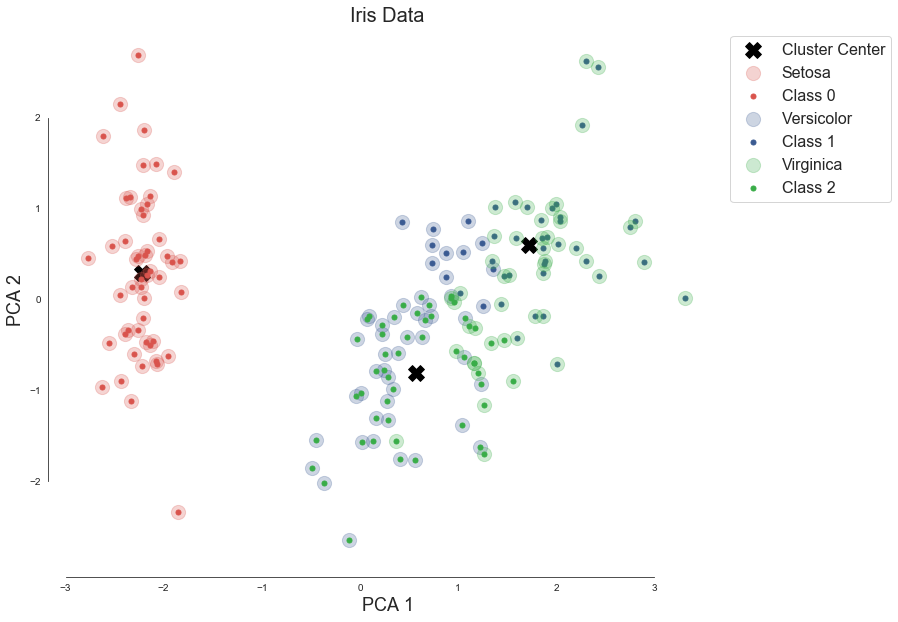

In [7]:
# Now we compare the cluster assignments to the real classes.

# Reduced features with real classes
cols = ['PCA1', 'PCA2', 'Species']
dt = pd.DataFrame(x_pca_label, columns = cols)

# Reduced Features with predicted classes
pc = pd.DataFrame(np.concatenate((x_pca, y_cluster.reshape(x.shape[0], 1)), axis=1), columns = cols)

# Two sets of colors, can modify these to ensure colors match 
# between known and predicted clusters.
# colors for true classes
clr = [sns.xkcd_rgb['pale red'], 
       sns.xkcd_rgb['denim blue'], 
       sns.xkcd_rgb['medium green']]

# colors for predicted classes(clusters)
pclr = [sns.xkcd_rgb['pale red'], 
        sns.xkcd_rgb['denim blue'],
        sns.xkcd_rgb['medium green']]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
plbls = ['Class 0', 'Class 1', 'Class 2']


# Predicted Clusters

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot cluster centers
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', 
           label='Cluster Center')

# Plot each species separately
for idx in range(3):
    
    # Plot species(real classes) as large points
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], 
               color=clr[idx], label=lbls[idx], alpha=0.25, s=200)

    # Plot assignd cluster as small point
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=pclr[idx], label=plbls[idx], alpha=1, s=25)

# Decorate Plot
ax.set(title='Iris Data', xlabel='PCA 1', ylabel='PCA 2')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2)
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)


### k-Means: Elbow Method

Clearly, one of the biggest challenges in using the k-means algorithm to find clusters is in selecting the value of $k$. In some cases, there might be a strong a priori reason to choose a specific value for $k$, such as with the Iris data and $k=3$. For a general data set, on the other hand, we need a method to identify the _best_ value for $k$. In these cases, the _elbow method_ provides a heuristic estimate that can provide a reasonable value.

The elbow method has several forms, all of which rely on some measure of the quality with which a given number of clusters best fits the data. In this notebook, we will use the **cluster inertia**, which is the sum total distance of every point to its cluster center. When the inertia is plotted against the number of clusters, the value starts high for small numbers of clusters, and as the number of clusters increases, this value will quickly decrease. This decrease arises since more clusters will, on average, reduce the distance between any given point and its cluster center. The extreme scenario is that when k equals to total number of data points, each data point is its own center, thus the total distance becomes 0. Eventually, however, the inertia levels off as existing clusters are broken into sub-groups. The **best** value for $k$ is selected as the _elbow_ point within this plot. In another word, we will choose a **k** so that increases in k won't reduce total distance significantly.

The following two Code cells demonstrate the _elbow method_. The first Code cell performs k-means clustering for different numbers of clusters(1 to 10). For each set of computed cluster centers, the inertia(total distance) is assigned to the `distances` array. The second Code cell plots the number of clusters versus the corresponding _inertia_. Notice how the _elbow_ is clearly seen at three clusters, where the steep drop changes to a much shallower slope.

-----

In [8]:
# Search for best number of clusters, from one to ten
n_clusters = np.arange(1, 11)
distances = np.zeros(n_clusters.shape[0])

# Perform k-means clustering for different numbers of clusters
# Use the inertia (or sum of total distances between points
# and cluster centers) as the performance metric.
for idx, nc in enumerate(n_clusters):
    # We build our model for nc clusters
    model = KMeans(n_clusters=nc, n_init=10, random_state=23)
    model.fit(x)
    distances[idx] = model.inertia_

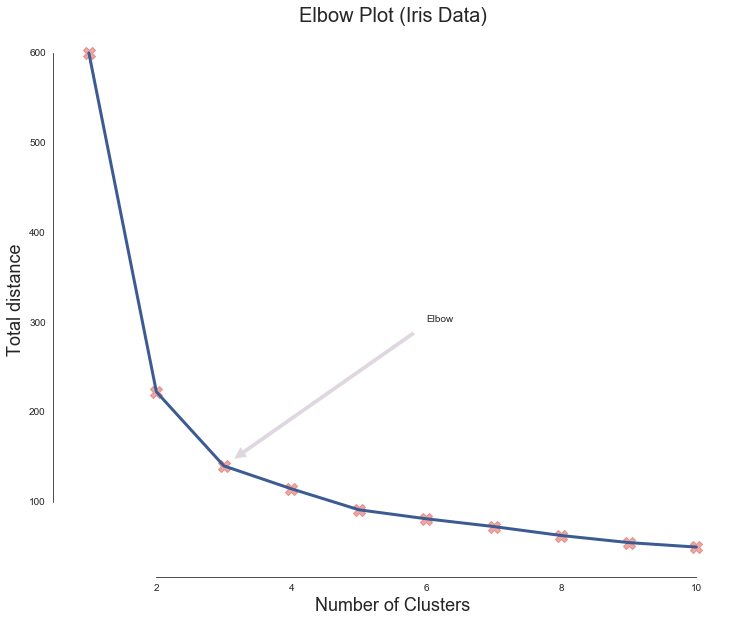

In [9]:
# Plot elbow method
fig, ax = plt.subplots(figsize=(12, 10))

# Draw points and connect them
ax.scatter(n_clusters, distances, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_clusters, distances, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'])

# Define elbow at three clusters
elb = (n_clusters[2], distances[2])

# Draw an arrow showing the elbow
ax.annotate('Elbow', xytext=[6, 300], xy=elb,
                arrowprops=dict(facecolor=sns.xkcd_rgb['dusty purple'], 
                                alpha=0.25, shrink=0.05))

# Decorate Plot
ax.set(title='Elbow Plot (Iris Data)', 
       xlabel='Number of Clusters', 
       ylabel='Total distance')
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)


### Features Characteristic of Clusters

We can use seaborn `pairplot` to view the feature characteristics of each cluster. 

In the next code cell, we add a 'cluster' column to iris dataset. Then plot a pairplot on all 4 features and the predicted clusters. We can focus on the last column of the pairplot which shows the relationships between each feature and cluster.

From the pairplot, we can see that:
- Cluster 0 has the smallest petal_length(3rd row) and petal_width(4th row). Acutally, cluster 0 can be clearly separated just by these two features. 
- Cluster 1 has the largest sepal_length(1st row), petal_length(3rd row) and petal_width(4th row), and mid sepal_width. 
- Cluster 2 has the smallest sepal_width and mid in other 3 features. 
- Cluster 1 and 2 overlaps in all 4 features which inidates that the separation between the two clusters are not very clean.
- The histogram in lower right corner of the pairplot grid show that the three clusters have similar number of data points which is inline with reality(each of the three species has 50 data points)

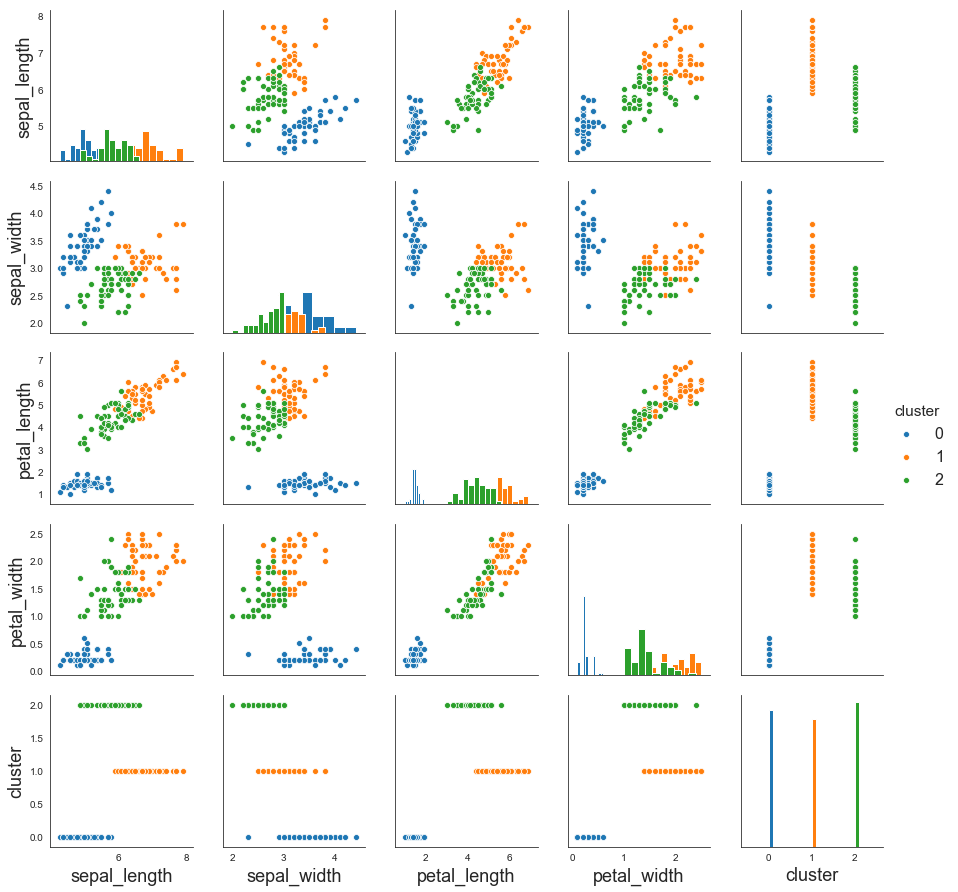

In [10]:
iris['cluster'] = y_cluster
grid = sns.pairplot( iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'cluster']], hue="cluster", diag_kind='hist')

-----
[[Back to TOC]](#Table-of-Contents)


## k-Means: Credit Card Data

While the Iris data enabled a simple introduction to the k-means algorithm and cluster finding in general, most data sets will contain more features. As a result, we now switch to a real world data with more features. Specifically, in the rest of this notebook we will apply the k-means algorithm to the credit card dataset which has 5 features. We will apply k-means on this dataset to develop a customer segmentation for marketing strategy.

The credit card dataset summarizes the usage behavior of 8636 active credit card holders during the last 6 months. This dataset is created for this course from a dataset with a lot more features. You may find the original credit card dataset on [Kaggle][ccd].

Following is the Data Dictionary for Credit Card dataset :

- TOTAL_PURCHASES : Amount of total purchases made from account 
- PRC_CASH_ADVANCE : Percent of total purchases that is cash in advance given by the user. Cash in advance purchases are typically on-line purchases.
- CREDIT_LIMIT : Limit of Credit Card for user 
- MINIMUM_PAYMENTS : Minimum amount of payments made by user 
- PRCFULLPAYMENT : Percent of full payment paid by user 

The first code cell below loads the credit card data into the notebook. The second code cell display the basic information of the dataset. The thrid code cell displays the basic statistics of the dataset. Please note that data understanding and data preparation are most import steps in data analytics. The two steps normally account for about 80% of total time and effort by analysts. But in this notebook we will focus on clustering(which is the modeling step in the CRISP-DM framework). We assume the data is already cleaned and we won't spend too much time on data understanding other than displaying basic statistics.

-----
[ccd]:https://www.kaggle.com/arjunbhasin2013/ccdata

In [11]:
df_cc = pd.read_csv('data/Credit_Card.csv')
df_cc.head()

,TOTAL_PURCHASES,PRC_CASH_ADVANCE,CREDIT_LIMIT,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,95.410000,0.000000,1000.0,139.509787,0.000000
1,6442.955483,0.999998,7000.0,1072.340217,0.222222
2,773.180000,0.000000,7500.0,627.284787,0.000000
3,16.010000,0.000000,1200.0,244.791237,0.000000
4,1333.290000,0.000000,1800.0,2407.246035,0.000000


In [12]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 5 columns):
TOTAL_PURCHASES     8636 non-null float64
PRC_CASH_ADVANCE    8636 non-null float64
CREDIT_LIMIT        8636 non-null float64
MINIMUM_PAYMENTS    8636 non-null float64
PRC_FULL_PAYMENT    8636 non-null float64
dtypes: float64(5)
memory usage: 337.4 KB


In [13]:
df_cc.describe()

,TOTAL_PURCHASES,PRC_CASH_ADVANCE,CREDIT_LIMIT,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000
mean,2019.619398,0.381541,4522.091030,864.304943,0.159304
std,2950.021139,0.442971,3659.240379,2372.566350,0.296271
min,0.010000,0.000000,50.000000,0.019163,0.000000
25%,379.667726,0.000000,1600.000000,169.163545,0.000000
50%,1095.557789,0.000000,3000.000000,312.452292,0.000000
75%,2556.502427,0.953255,6500.000000,825.496463,0.166667
max,49597.746886,1.000000,30000.000000,76406.207520,1.000000


---
Now the data is loaded, we standardize it in the next code cell. Then we plot the elbow plot to figure out proper culster number. There is no clear elbow in the plot which normally indicate that there's no clear clusters in the dataset. This is very common in real life data.

In this notebook, we will arbitrarily choose k=6 for the k-means model.

In [14]:
x_cc = StandardScaler().fit_transform(df_cc)

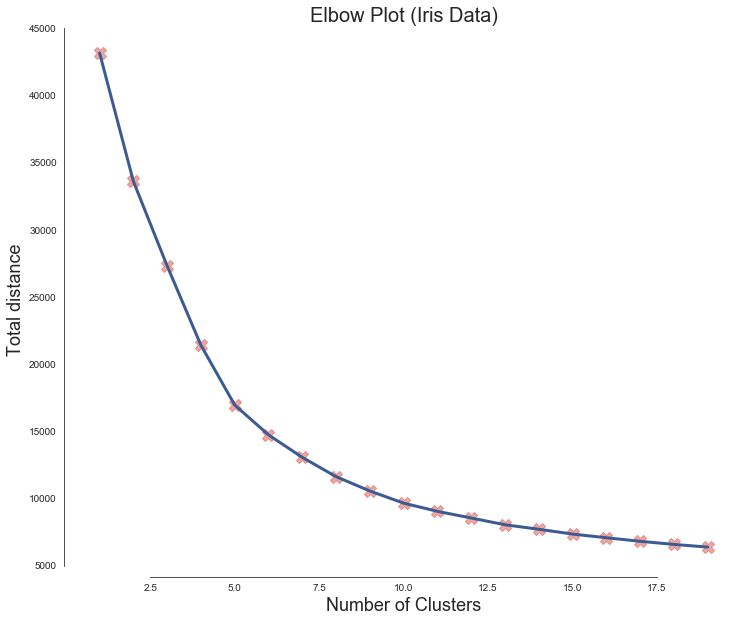

In [15]:
# Search for best number of clusters, from one to ten
n_clusters = np.arange(1, 20)
distances = np.zeros(n_clusters.shape[0])

# Perform k-means clustering for different numbers of clusters
# Use the inertia (or sum of total distances between points
# and cluster centers) as the performance metric.
for idx, nc in enumerate(n_clusters):
    # We build our model for nc clusters
    model = KMeans(n_clusters=nc, n_init=10, random_state=23)
    model.fit(x_cc)
    distances[idx] = model.inertia_
# Plot elbow method
fig, ax = plt.subplots(figsize=(12, 10))

# Draw points and connect them
ax.scatter(n_clusters, distances, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_clusters, distances, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'])

# Define elbow at three clusters
elb = (n_clusters[2], distances[2])

# Decorate Plot
ax.set(title='Elbow Plot (Iris Data)', 
       xlabel='Number of Clusters', 
       ylabel='Total distance')
sns.despine(offset=5, trim=True)

---
In the following code cells, we create the estimator by specifying six clusters, by indicating that twenty-five different runs should be performed, and by specifying a random state for reproducibility.

We then print out the count of each clusters. Clust 4 and 5 only has 56 and 69 data points which is too small to be meaningful.

In [16]:
# We build our model assuming three clusters
k_means = KMeans(n_clusters=6, n_init=25, random_state=23)

# We fit our data to assign classes
k_means.fit(x_cc)

# Obtain the predictions
y_pred = k_means.predict(x_cc)

In [17]:
from collections import Counter 
cnt =  Counter(np.sort(y_pred))

# Display some basic results of the clustering
print('DBSCAN Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

DBSCAN Cluster membership.
------------------------------
Cluster 0     : 3436 members
Cluster 1     : 2572 members
Cluster 2     : 1270 members
Cluster 3     : 1233 members
Cluster 4     :   56 members
Cluster 5     :   69 members


---
Next, we plot pairplot of the features and clusters to find out characteristics of each cluster. The pairplot indicates there's really no clear separations among clusters. But we can still draw some conclusions from the plot:
- cluster 0 has the most data points. Accounts in this cluster have low credit limit, are low on total purchase, don't make much on-line purchase.
- accounts in cluster 1 made most purchase on-line, this is indicated by the last column in the 2nd row. The accounts have low credit limit and low total purchase. Accounts in this cluster may belong to the younger generation.
- accounts in cluster 2 made more full payments than other that of other clusters. These accounts are _safe_ or _conservative_ users who are more likely to make full payment. 
- accounts in cluster 4, on the other hand, tend to make minimum payments.
- accounts in cluster 5 made most total purchases, their credit limit is on the high side. They didn't make minimum payment often.

We can then develop a marketing strategy based on this information. For example, we may push on-line sales information to accounts in cluster 1; or we may provide more promotions to safe users in cluster 2.

Again, this analysis is very primitive. There are a lot of in-depth analysis that need to be done to get more useful information. Many times, you will have to accept that fact that the data you have may not provide enough information for a meaningful clustering analysis.

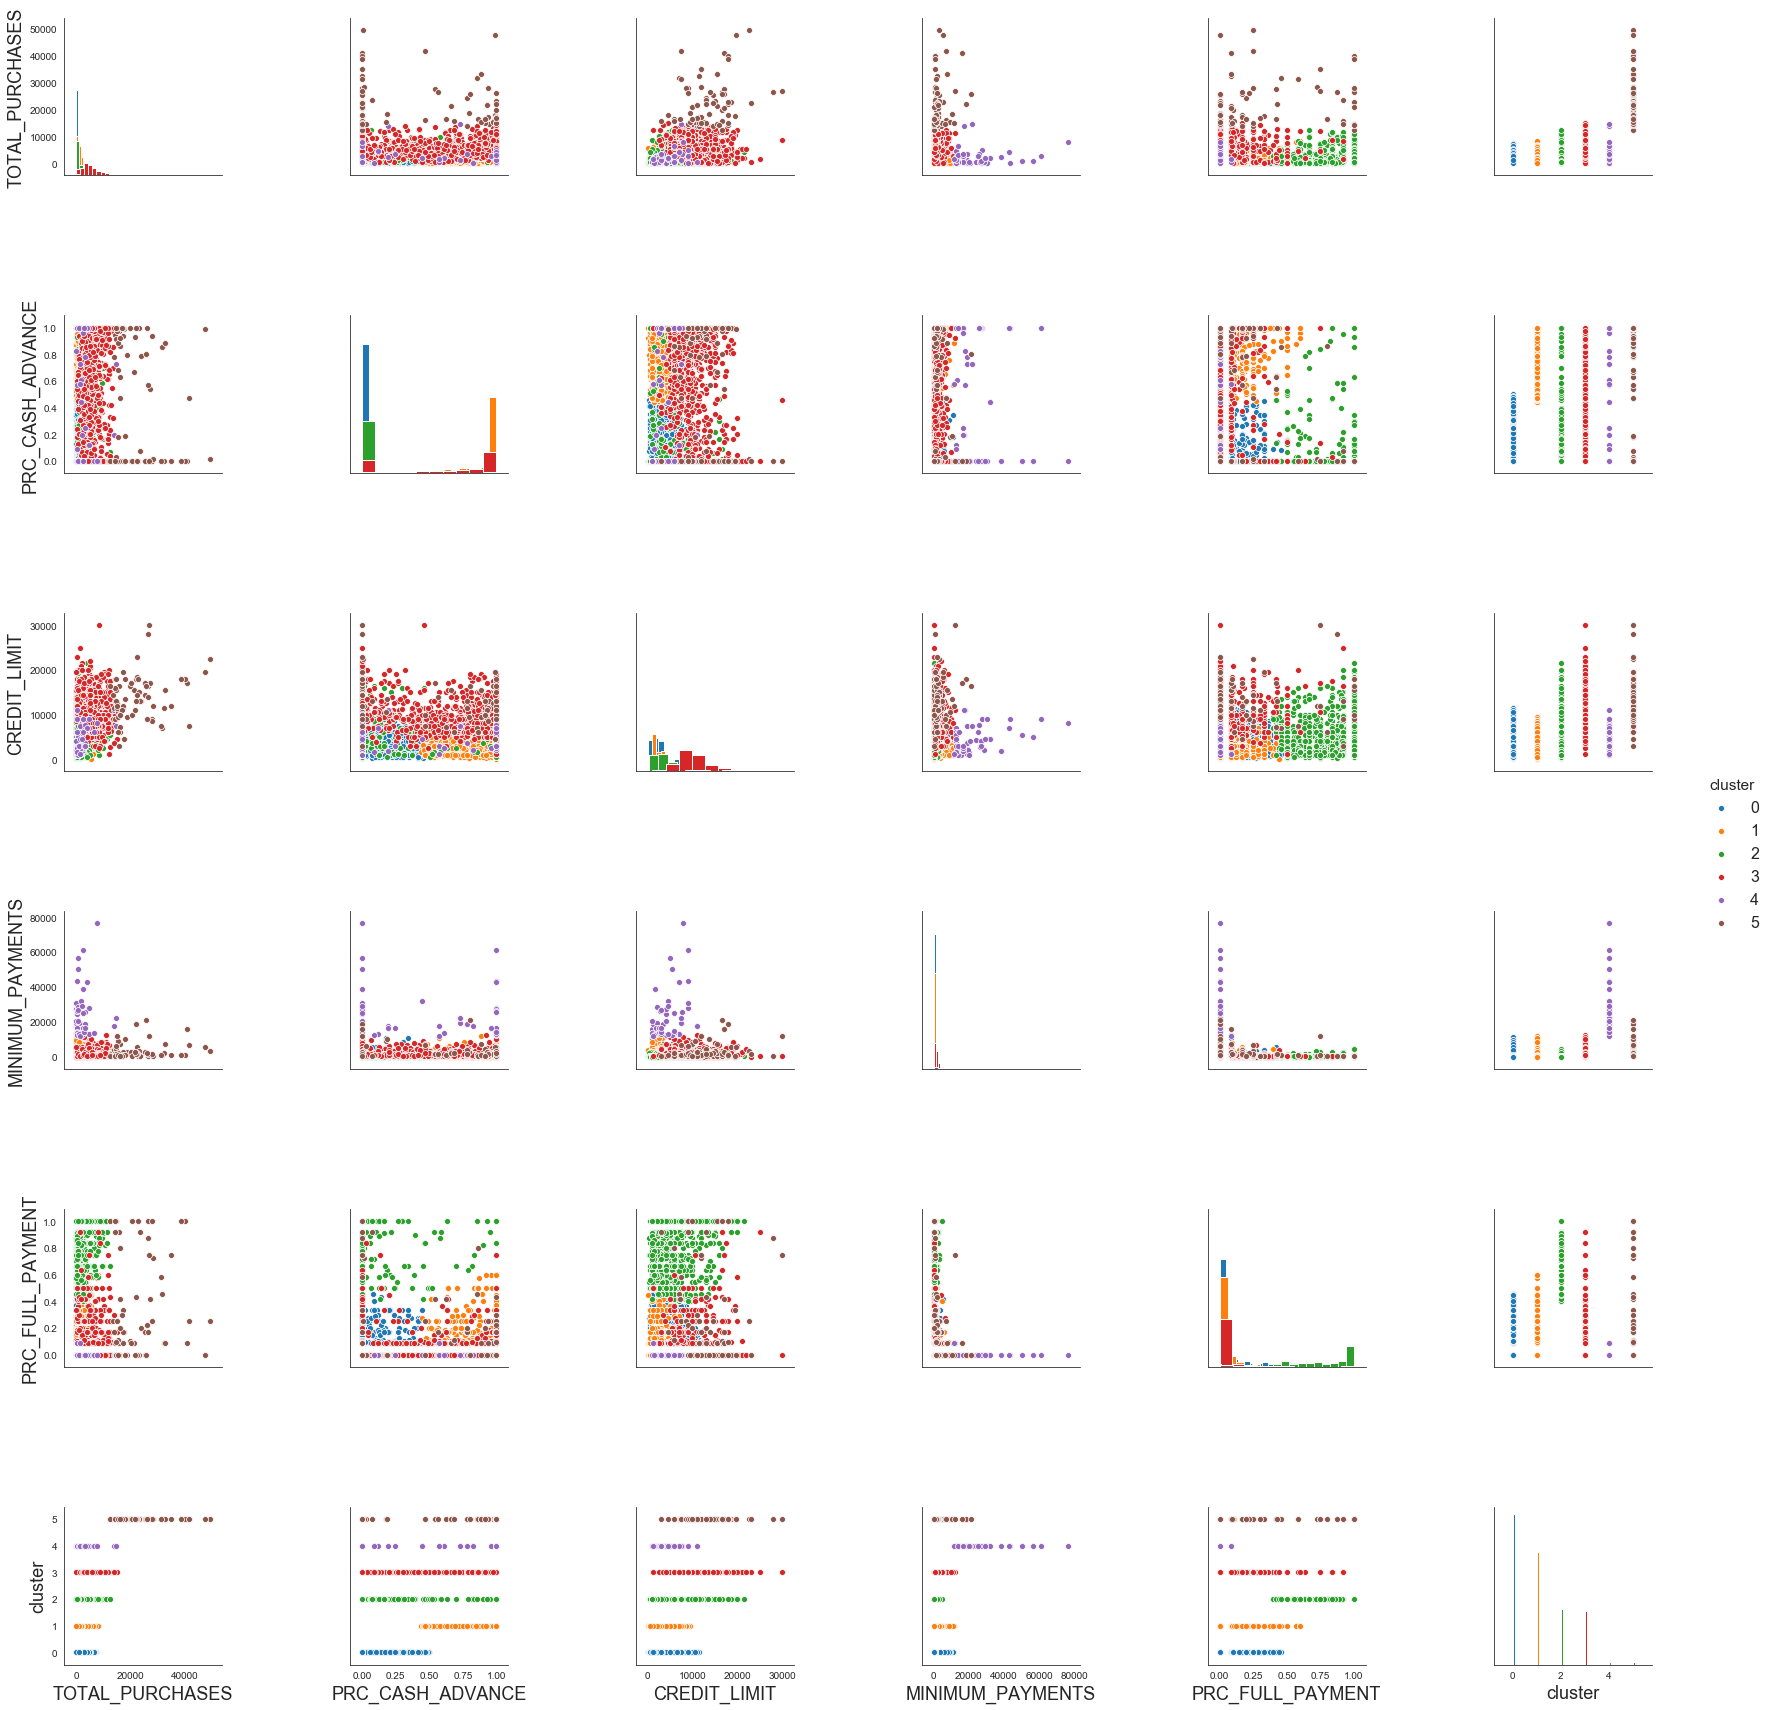

In [18]:
df_cc['cluster'] = y_pred
grid = sns.pairplot( df_cc, hue="cluster", diag_kind='hist')
grid.fig.set_size_inches(25,25)

---
In the following code cell, we first use PCA to transform the credit card dataset to a two dimensional space, then plot the data points in the new two-dimensional space. We plot each cluster in different colors with their cluster center represented by **X**. This scatter plot is a common way to examine whether the dataset has clear separations between clusters.

From this plot we can see that there's really no clear clustering patterns.

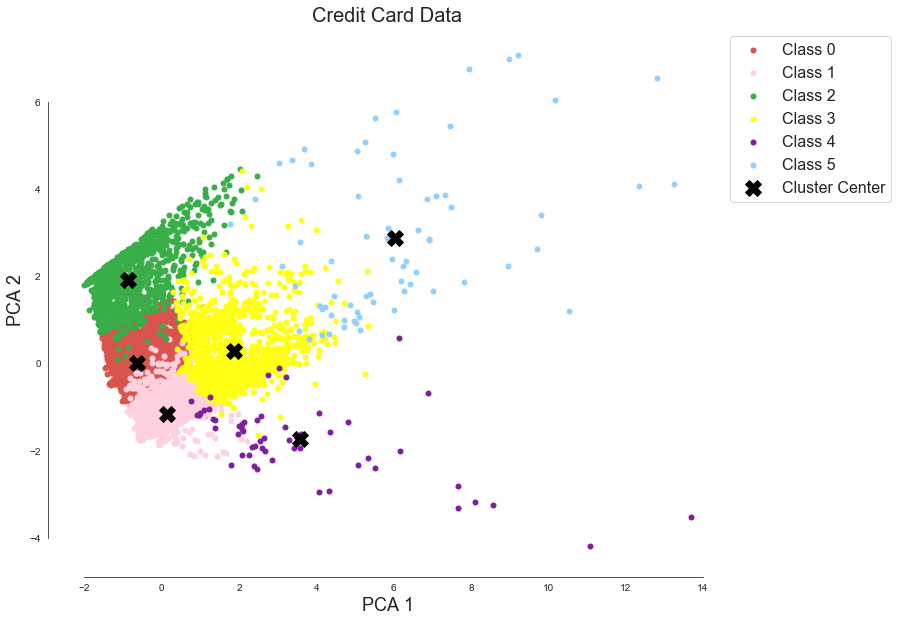

In [19]:
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
xx_cc = pca.fit_transform(x_cc)

# append label to reduced dataset.
data = np.concatenate((xx_cc, y_pred.reshape(x_cc.shape[0], 1)), axis=1)

# Reduced features with real classes
cols = ['PCA1', 'PCA2', 'Class']

# Reduced Features with predicted classes
pc = pd.DataFrame(data, columns = cols)

cc = k_means.cluster_centers_
cc_pca = pca.transform(cc)

# Two sets of colors, can modify these to ensure colors match 
# between known and predicted clusters.
pclr = [sns.xkcd_rgb['pale red'], 
        sns.xkcd_rgb['light pink'],
        sns.xkcd_rgb['medium green'],
        sns.xkcd_rgb['yellow'],
        sns.xkcd_rgb['purple'],
        sns.xkcd_rgb['light blue']]

# Label data
plbls = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']


# Predicted Clusters

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each species separately
for idx in range(6):
    
    # Plot assignd cluster as small point
    tmp_pdf = pc[pc['Class'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=pclr[idx], label=plbls[idx], alpha=1, s=25)

# Plot cluster centers
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', 
           label='Cluster Center')

# Decorate Plot
ax.set(title='Credit Card Data', xlabel='PCA 1', ylabel='PCA 2')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2)
sns.despine(offset=5, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)

### k-Means: Performance

The previous example demonstrated, visually, the performance of the k-means algorithm on the credit card data. However, we often want a quantitative [measurement of performance][skpm]. Measuring the performance of a clustering algorithm is more challenging than scoring a classifier or regressor, especially since the process is unsupervised, and thus labels aren't always available. When labels are not available, we can, in some cases, compare the predicted labels from different clustering algorithms.

The scikit learn library provides a number of different performance metrics for clustering. Most are for the case when the ground truth(true labels) is available. Please check out the details of these metrics on [scikit learn][skpm]. Only one of them is for the case when ground truth is not available:

- [Silhouette][sks]: takes values in the range [-1, 1] and does not require ground truth labels. This score is based on the intra-cluster distance and the mean nearest-cluster distance (this is the distance to the closest cluster to which the data were not assigned). A value of one means highly dense clustering, and a value of minus one indicates incorrect clustering (since the data are often closer to a different cluster than the one to which they are assigned). A value of zero indicates overlapping clusters

The following Code cell computes the Silhouette score for the credit card data. The score is low, which indicates that there is overlap between the clusters, which we saw in the scatter plot in the two-dimensional space.


----
[skpm]: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
[sks]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [20]:
from sklearn.metrics import silhouette_score
silhouette_score(x_cc, y_pred)

0.4145494094664024

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the k-means algorithm on the credit card dataset.  Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the number of clusters (higher and lower) in the k-means clustering algorithm, how do the results change? 

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [k-medians][1] clustering
1. Blog article on [k-means clustering][3]
2. The [Scikit Learn k-means algorithm][2]

-----

[1]: https://en.wikipedia.org/wiki/K-medians_clustering
[2]: http://scikit-learn.org/stable/modules/clustering.html#k-means
[3]: https://www.datascience.com/blog/k-means-clustering

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 